<a href="https://colab.research.google.com/github/soobook/TensorFlow-DL/blob/main/code/TF13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 13회차: RNN을 활용한 항공 여행자 수 예측 (3) - 모델 학습 및 평가

## RNN 구현

In [1]:
# 운영체제 경로, 파일 조작 등을 위한 표준 라이브러리
import os
# 데이터프레임 형태로 데이터 처리 (엑셀/CSV 등 표 형식 데이터 분석)
import pandas as pd
# 수치 계산, 배열 연산 등을 위한 과학 계산 라이브러리
import numpy as np
# 딥러닝 모델 구성 및 학습을 위한 프레임워크 (RNN, LSTM 등 사용 가능)
import tensorflow as tf
# KaggleHub에서 공개 데이터셋을 다운로드할 수 있는 유틸리티
import kagglehub
# 데이터 시각화를 위한 기본 그래프 라이브러리
import matplotlib.pyplot as plt
# 데이터 정규화를 위한 전처리 도구 (예: 0~1 사이로 MinMax 스케일링)
from sklearn.preprocessing import MinMaxScaler
# MSE와 MAE 성능 지표 계산 함수 임포트
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# -------------------------------------------------------------
# 1. 데이터 로드 및 전처리
# -------------------------------------------------------------

# KaggleHub에서 "AirPassengers" 시계열 데이터셋을 다운로드
# 데이터셋 ID: pattnaiksatyajit/air-passengers
path = kagglehub.dataset_download("pattnaiksatyajit/air-passengers")
# 다운로드한 경로에서 'AirPassengers.csv' 파일 경로 생성
csv_file_path = os.path.join(path, "AirPassengers.csv")
# CSV 파일을 판다스 DataFrame으로 읽어오기
df = pd.read_csv(csv_file_path)

# 문자열 형식의 'Month' 열을 pandas의 datetime 타입으로 변환
# 예: '1949-01' → Timestamp('1949-01-01 00:00:00')
df['Month'] = pd.to_datetime(df['Month'])

# 'Month' 열을 DataFrame의 인덱스로 설정
# 시간 순서 기반 시계열 분석, 시각화 등에 유리하게 만듦
# inplace=True → 원본 df를 바로 수정
df.set_index('Month', inplace=True)

# -------------------------------------------------------------
# 2. MinMax Scaling 적용
#    '#Passengers' 열을 0~1 범위로 정규화
# -------------------------------------------------------------
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['#Passengers']])  # 결과는 numpy array

100%|██████████| 764/764 [00:00<00:00, 1.44MB/s]

Extracting files...


In [3]:
# -------------------------------------------------------------
# 3. Sliding Window 시퀀스 생성
# -------------------------------------------------------------
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 12
X_all, y_all = create_sequences(scaled_data, SEQ_LENGTH)

In [4]:
# -------------------------------------------------------------
# 4. 시간 순서 유지하며 Train/Val/Test 분할
# -------------------------------------------------------------

# 전체 시퀀스 개수 확인 (Sliding Window로 생성된 샘플 수)
n = len(X_all)
# 훈련 데이터 종료 인덱스: 전체의 70% 지점
train_end = int(n * 0.7)
# 검증 데이터 종료 인덱스: 전체의 85% 지점
val_end = int(n * 0.85)

# 훈련 세트: 시계열 앞부분 70%
X_train, y_train = X_all[:train_end], y_all[:train_end]
# 검증 세트: 다음 15% (하이퍼파라미터 튜닝용)
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
# 테스트 세트: 가장 마지막 15% (모델 성능 평가용)
X_test, y_test = X_all[val_end:], y_all[val_end:]

## RNN 학습

#### 단일 시계열 데이터를 예측하기 위한 RNN(Recurrent Neural Network) 모델 정의
- 앞의 12개의 자료로 다음 하나를 예측
- 내부 순환층 1개, 은닉층 벡터 64
- Adam: 학습 속도와 안정성이 뛰어난 옵티마이저
- loss='mse': 평균제곱오차(Mean Squared Error)로 학습 손실 계산


In [5]:
# 5. RNN 모델 정의
# 순차적 모델 구성
model = tf.keras.Sequential([
    # 입력 데이터의 형태: 시계열 길이(12) x 1개 특성
    tf.keras.Input(shape=(SEQ_LENGTH, 1)),
    # RNN 셀 64개, tanh 활성화 함수 사용
    tf.keras.layers.SimpleRNN(64, activation='tanh'),
    # 출력층: 연속적인 수치 예측(1차원)
    tf.keras.layers.Dense(1)
])

# Adam 최적화, 손실 함수는 평균제곱오차(MSE)
model.compile(optimizer='adam', loss='mse')

In [6]:
# 모델 요약 출력
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# 6. 콜백: 10 에폭마다 출력 + EarlyStopping 정의
class PrintEvery10Epochs(tf.keras.callbacks.Callback): # 커스텀 콜백 클래스 정의
    def on_epoch_end(self, epoch, logs=None):          # 에폭 종료 시 실행될 함수
        if (epoch + 1) % 10 == 0:                      # 매 10번째 에폭마다 출력
            print(f"Epoch {epoch+1:3d} - loss: {logs['loss']:.4f}, val_loss: {logs['val_loss']:.4f}")

early_stopping = tf.keras.callbacks.EarlyStopping(     # 조기 종료 콜백 정의
    monitor='val_loss',                                # 검증 손실(val_loss)을 모니터링
    patience=40,                                       # 40 에폭 동안 개선 없으면 학습 종료
    restore_best_weights=True,                         # 가장 좋은 가중치로 복원
    verbose=1                                          # 조기 종료 시 메시지 출력
)

In [8]:
# 7. 모델 학습
# 모델 학습 시작, 반환값은 학습 기록(history)
history = model.fit(
    X_train, y_train,                                # 학습 데이터 (입력과 타깃)
    validation_data=(X_val, y_val),                  # 검증 데이터 (val_loss 계산용)
    epochs=300,                                      # 최대 300 에폭까지 반복 학습
    batch_size=16,                                   # 미니배치 크기: 한 번에 16개 샘플로 학습
    verbose=0,                                       # 학습 로그 출력 끔 (출력은 콜백으로 처리)
    callbacks=[PrintEvery10Epochs(), early_stopping] # 에폭별 출력과 조기 종료 콜백 설정
)

Epoch  10 - loss: 0.0006, val_loss: 0.0016
Epoch  20 - loss: 0.0005, val_loss: 0.0015
Epoch  30 - loss: 0.0006, val_loss: 0.0014
Epoch  40 - loss: 0.0005, val_loss: 0.0012
Epoch  50 - loss: 0.0005, val_loss: 0.0014
Epoch 51: early stopping
Restoring model weights from the end of the best epoch: 11.


In [9]:
# 시각화 준비
!pip install koreanize_matplotlib
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 48.8 MB/s eta 0:00:00


## RNN 평가

In [10]:
# 8. 예측 및 시각화
predicted = model.predict(X_test)
predicted_inverse = scaler.inverse_transform(predicted)
y_test_inverse = scaler.inverse_transform(y_test)

# 9. 성능 평가 지표 출력
mse = mean_squared_error(y_test_inverse, predicted_inverse)
mae = mean_absolute_error(y_test_inverse, predicted_inverse)
print(f"[테스트 성능 평가] MSE: {mse:.2f}, MAE: {mae:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
[테스트 성능 평가] MSE: 1587.67, MAE: 35.06


In [11]:
# 데이터프레임의 앞쪽 날짜 인덱스 4개를 출력 (시계열 시작 확인용)
print(df.index[:4])
# 데이터프레임의 뒤쪽 날짜 인덱스 4개를 출력 (시계열 끝 확인용)
print(df.index[-4:])

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01'], dtype='datetime64[ns]', name='Month', freq=None)
DatetimeIndex(['1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='Month', freq=None)


In [12]:
# 테스트 예측 구간의 시작 인덱스를 계산 (시퀀스 길이 + 학습+검증 데이터 길이)
test_start = SEQ_LENGTH + val_end
# 테스트 예측 구간의 끝 인덱스를 계산 (테스트 샘플 개수만큼 범위 설정)
test_end = SEQ_LENGTH + val_end + len(y_test)

# 원본 시계열 인덱스에서 테스트 구간에 해당하는 날짜 범위 추출
dates = df.index[test_start : test_end]

# 테스트 구간 날짜 리스트의 앞쪽 4개 출력 (정상적으로 날짜 슬라이싱 되었는지 확인용)
print(dates[:4])
# 테스트 구간 날짜 리스트의 뒤쪽 4개 출력 (끝 범위가 잘렸는지 확인하는 디버깅용)
print(dates[-4:])

DatetimeIndex(['1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01'], dtype='datetime64[ns]', name='Month', freq=None)
DatetimeIndex(['1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='Month', freq=None)


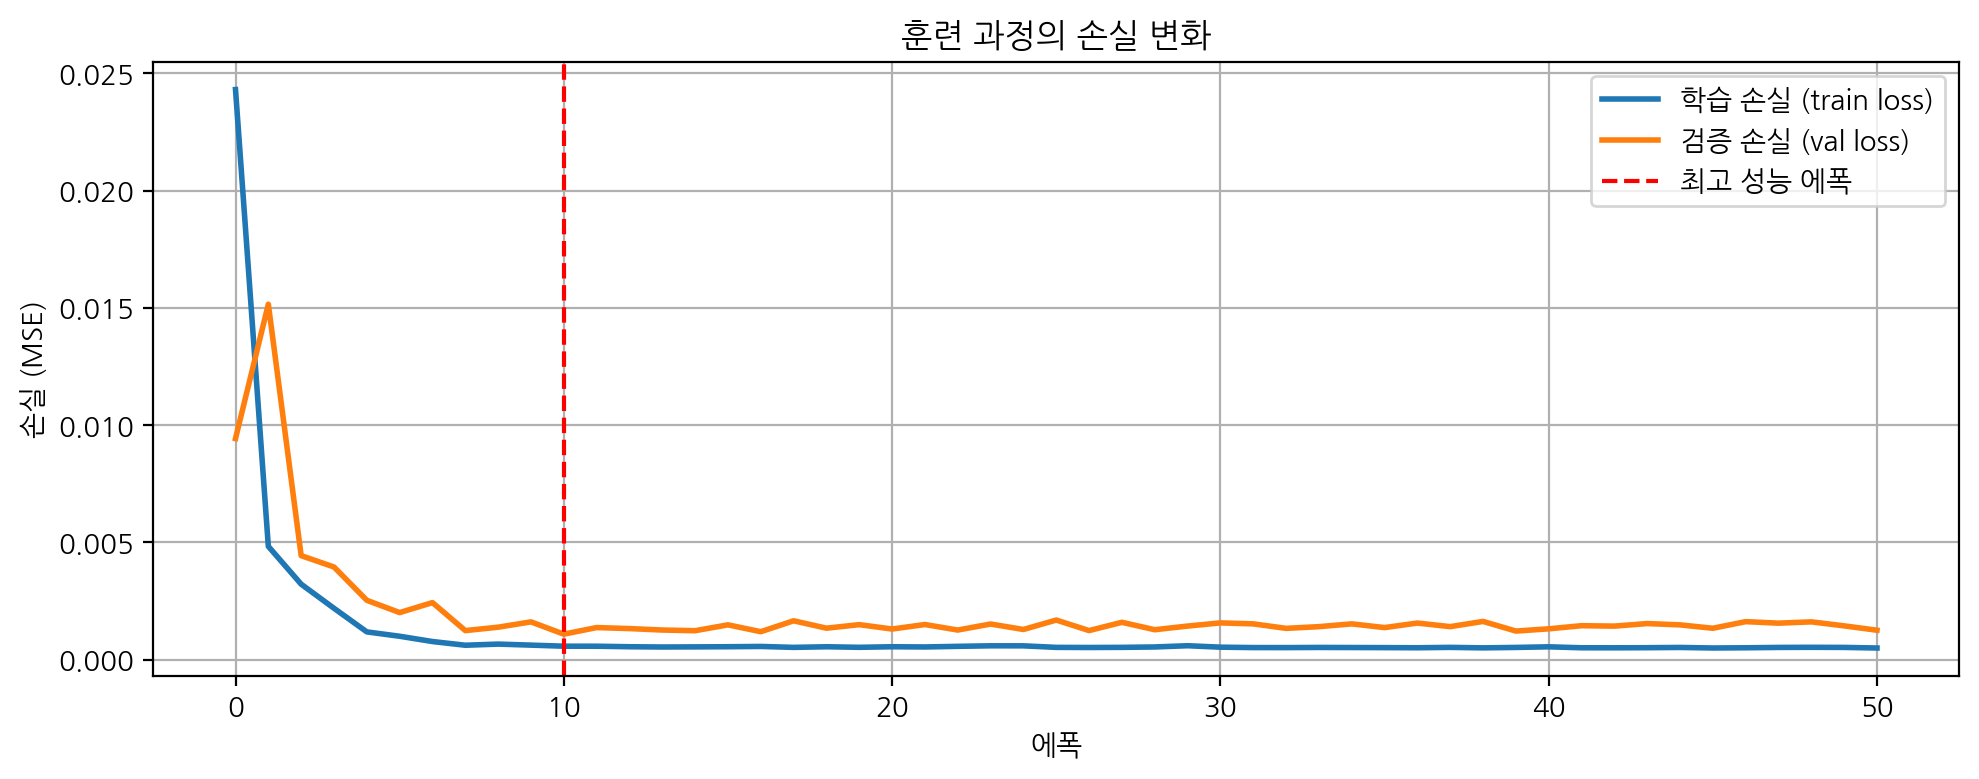

In [13]:
# 10. 학습 손실 시각화 (Loss Visualization)
# 시각화 준비
# !pip install koreanize_matplotlib
# import koreanize_matplotlib
# %config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='학습 손실 (train loss)', linewidth=2)
plt.plot(history.history['val_loss'], label='검증 손실 (val loss)', linewidth=2)
# val_loss 리스트 중에서 가장 낮은 값의 인덱스(epoch 번호)로 세로(vertical line)로 수직선 그리기
plt.axvline(np.argmin(history.history['val_loss']), color='red', linestyle='--', label='최고 성능 에폭')
plt.title('훈련 과정의 손실 변화')
plt.xlabel('에폭')
plt.ylabel('손실 (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

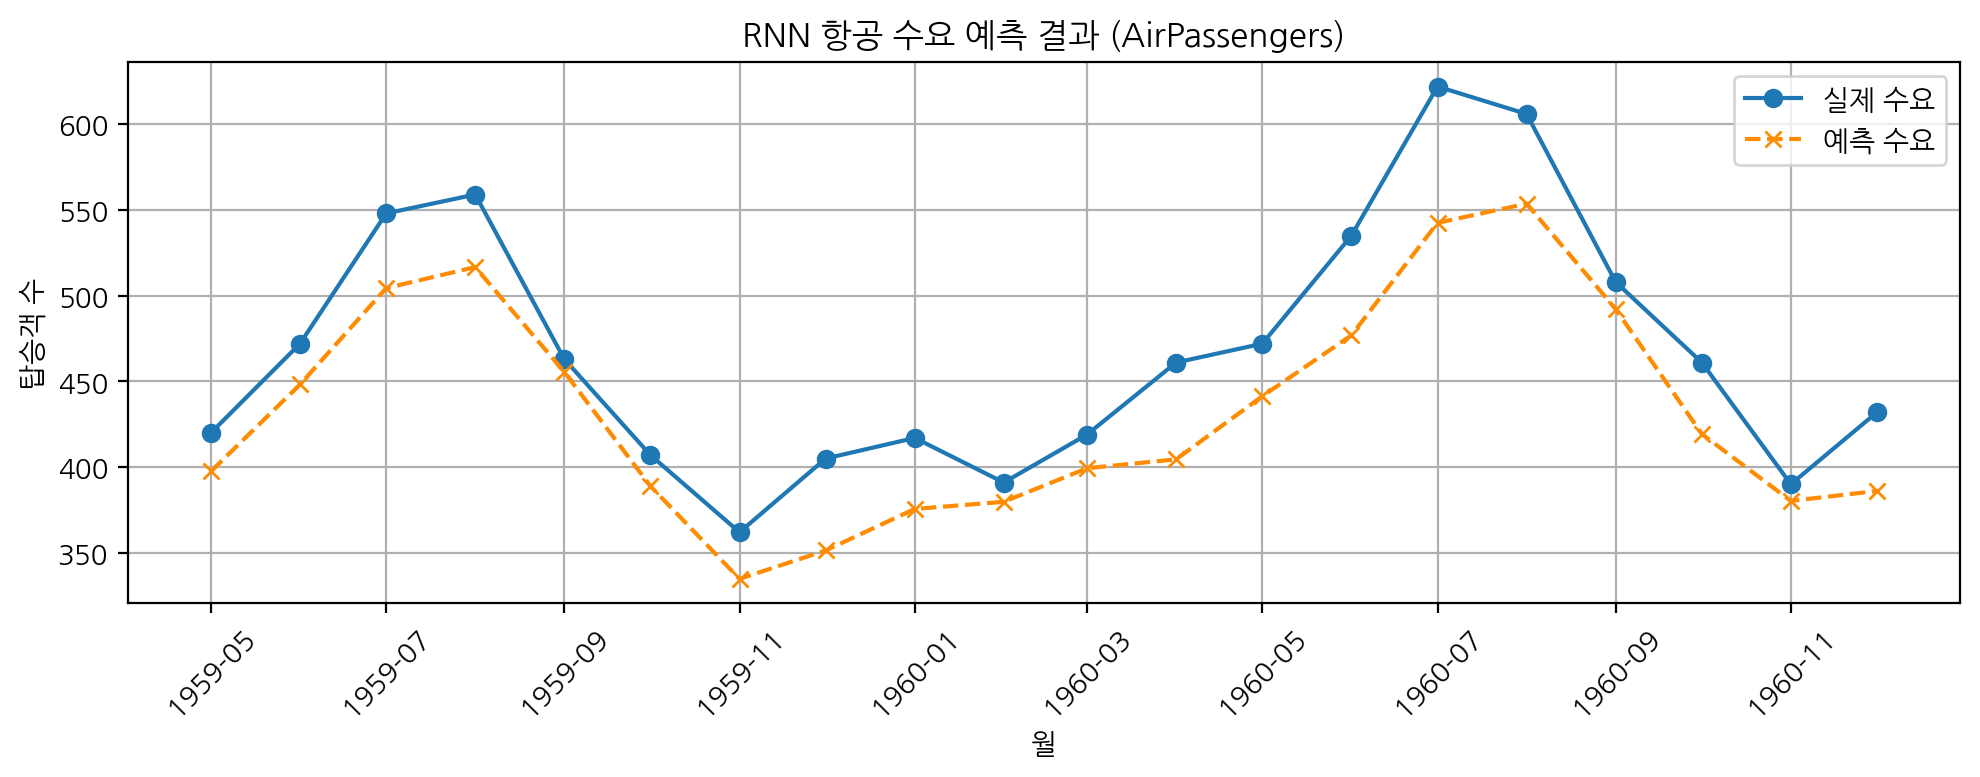

In [14]:
# 11. 예측 결과 시각화
plt.figure(figsize=(10, 4))
plt.plot(dates, y_test_inverse, 'o-', label='실제 수요')
plt.plot(dates, predicted_inverse, 'x--', label='예측 수요', color='darkorange')
plt.title("RNN 항공 수요 예측 결과 (AirPassengers)")
plt.xlabel("월")
plt.ylabel("탑승객 수")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 학습 종료

## EarlyStopping 없이

Using Colab cache for faster access to the 'air-passengers' dataset.
Epoch  10 - loss: 0.0007, val_loss: 0.0015
Epoch  20 - loss: 0.0006, val_loss: 0.0014
Epoch  30 - loss: 0.0007, val_loss: 0.0019
Epoch  40 - loss: 0.0006, val_loss: 0.0012
Epoch  50 - loss: 0.0007, val_loss: 0.0039
Epoch  60 - loss: 0.0005, val_loss: 0.0012
Epoch  70 - loss: 0.0005, val_loss: 0.0016
Epoch  80 - loss: 0.0006, val_loss: 0.0010
Epoch  90 - loss: 0.0005, val_loss: 0.0013
Epoch 100 - loss: 0.0005, val_loss: 0.0012
Epoch 110 - loss: 0.0005, val_loss: 0.0018
Epoch 120 - loss: 0.0005, val_loss: 0.0017
Epoch 130 - loss: 0.0006, val_loss: 0.0010
Epoch 140 - loss: 0.0005, val_loss: 0.0014
Epoch 150 - loss: 0.0005, val_loss: 0.0023
Epoch 160 - loss: 0.0005, val_loss: 0.0014
Epoch 170 - loss: 0.0005, val_loss: 0.0016
Epoch 180 - loss: 0.0005, val_loss: 0.0024
Epoch 190 - loss: 0.0005, val_loss: 0.0011
Epoch 200 - loss: 0.0005, val_loss: 0.0026
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


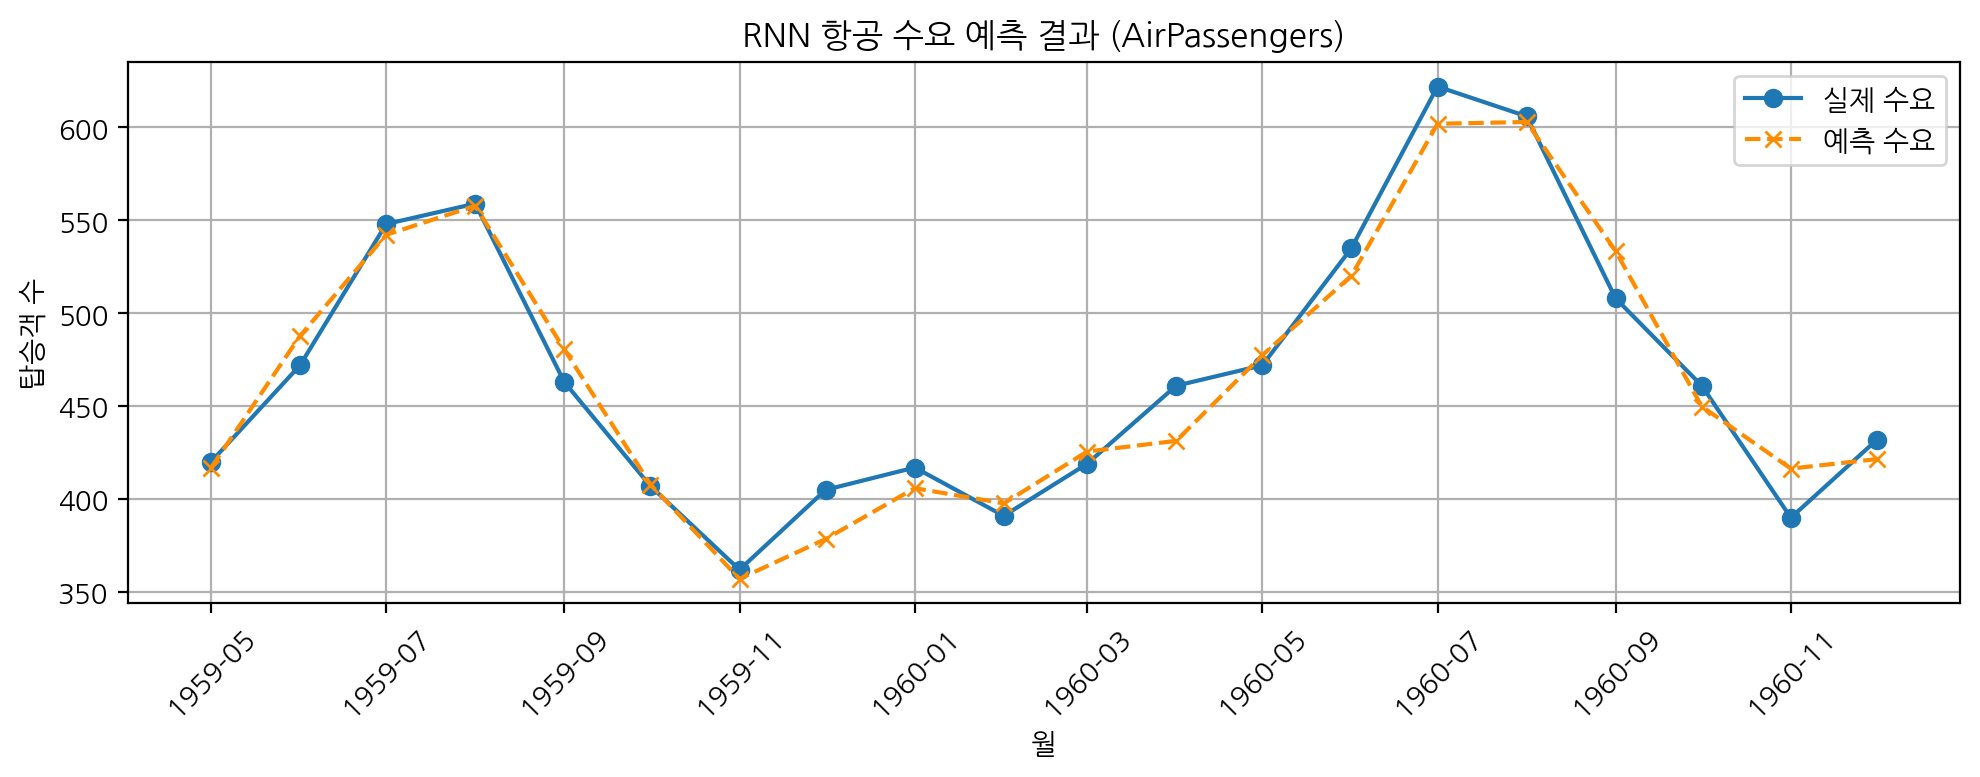

In [15]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import kagglehub
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 전처리
path = kagglehub.dataset_download("pattnaiksatyajit/air-passengers")
csv_file_path = os.path.join(path, "AirPassengers.csv")
df = pd.read_csv(csv_file_path)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# 2. MinMax Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['#Passengers']])

# 3. Sliding Window 시퀀스 생성
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 12
X_all, y_all = create_sequences(scaled_data, SEQ_LENGTH)

# 4. 시간 순서 유지하며 Train/Val/Test 분할
n = len(X_all)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test = X_all[val_end:], y_all[val_end:]

# 5. RNN 모델 정의
model = tf.keras.Sequential([
    tf.keras.Input(shape=(SEQ_LENGTH, 1)),
    tf.keras.layers.SimpleRNN(64, activation='tanh'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 6. 10 에폭마다 로그 출력 콜백
class PrintEvery10Epochs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d} - loss: {logs['loss']:.4f}, val_loss: {logs['val_loss']:.4f}")

# 7. 모델 학습
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=16,
    verbose=0,
    callbacks=[PrintEvery10Epochs()]
)

# 8. 예측 및 시각화
predicted = model.predict(X_test)
predicted_inverse = scaler.inverse_transform(predicted)
y_test_inverse = scaler.inverse_transform(y_test)

# 테스트 시점의 날짜 복원
dates = df.index[SEQ_LENGTH + val_end : SEQ_LENGTH + val_end + len(y_test)]

plt.figure(figsize=(10, 4))
plt.plot(dates, y_test_inverse, 'o-', label='실제 수요')
plt.plot(dates, predicted_inverse, 'x--', label='예측 수요', color='darkorange')
plt.title("RNN 항공 수요 예측 결과 (AirPassengers)")
plt.xlabel("월")
plt.ylabel("탑승객 수")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 종료